In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [35]:
img_no = []

for file in os.listdir('brain_tumor_dataset/no'):
    file = cv2.imread(f'brain_tumor_dataset/no/{file}')
    file = file[:, :, 0]
    file = cv2.resize(file, (100, 100))
    img_no.append(file)

img_no = torch.tensor(img_no, dtype=torch.float64).view(98, 1, 100, 100)

In [37]:
img_yes = []

for file in os.listdir('brain_tumor_dataset/yes'):
    file = cv2.imread(f'brain_tumor_dataset/yes/{file}')
    file = file[:, :, 0]
    file = cv2.resize(file, (100, 100))
    img_yes.append(file)

img_yes = torch.tensor(img_yes, dtype=torch.float64).view(155, 1, 100, 100)

In [39]:
test_size = 20

img_yes_test = img_yes[-test_size:, :, :, :]
img_yes_train = img_yes[:-test_size, :, :, :]

img_no_test = img_no[-test_size:, :, :, :]
img_no_train = img_no[:-test_size, :, :, :]

In [40]:
x_train = torch.cat((img_yes_train, img_no_train))
x_test = torch.cat((img_yes_test, img_no_test))

print(f'train shape: {x_train.shape}')
print(f'test shape: {x_test.shape}')

train shape: torch.Size([213, 1, 100, 100])
test shape: torch.Size([40, 1, 100, 100])


In [41]:
y_train = []

for i in range(213):
    if i < 135:
        y_train.append(1)
    else:
        y_train.append(0)

y_train = torch.tensor(y_train, dtype=torch.int64)

In [42]:
y_test = []

for i in range(40):
    if i < 20:
        y_test.append(1)
    else:
        y_test.append(0)

y_test = torch.tensor(y_test, dtype=torch.int64)

In [43]:
print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')

y train shape: torch.Size([213])
y test shape: torch.Size([40])


## Nerual Network


In [50]:
class Net(nn.Module):

    def __init__(self):
        #this inherits stuff from the pytorch nn class
        super(Net, self).__init__()

        #image in size = (100, 100)
        self.conv1 = nn.Conv2d(1, 10, 10, stride=2)
        self.conv1_drop = nn.Dropout2d(0.1)
        #image size = (23, 23)
        self.conv2 = nn.Conv2d(10, 20, 3)
        #image size = (11, 11)
        self.conv3 = nn.Conv2d(20, 30, 3)
        #image size(4, 4)
        self.lin1 = nn.Linear(480, 50)
        self.lin1_drop = nn.Dropout(0.1)
        self.lin2 = nn.Linear(50, 2)

    def forward(self, x):
        x = (x / 255).float()
        x = F.max_pool2d(F.relu(self.conv1_drop(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, 480)
        x = self.lin1_drop(self.lin1(x))
        x = self.lin2(x)

        return x

In [51]:
model = Net()
opt = torch.optim.SGD(model.parameters(), lr=0.04, momentum=0.7)

In [52]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, 64, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, 40)

In [53]:
def fit(model, opt, train_dl, test_dl, epochs):
    for epoch in range(epochs):
        model.train()
        batch_num = 0
        train_loss = 0.0
        for xb, yb in train_dl:
            batch_num += 1
            loss = F.cross_entropy(model.forward(xb), yb)
            train_loss += loss.item()

            loss.backward()
            opt.step()
            opt.zero_grad()

            model.eval()
            with torch.no_grad():
                test_losses = [F.cross_entropy(model.forward(xb), yb) for xb, yb in test_dl]
                test_loss = sum(test_losses) / len(test_losses)
        if (epoch + 1) % 5 == 0:
            print(f"epoch: {epoch + 1} ======> training loss: {round(float(train_loss / batch_num), 3)}   test loss: {round(float(test_loss), 3)}")     

In [48]:
fit(model, opt, train_dl, test_dl, 60)

epoch: 5 ======> training loss: 0.656   test loss: 0.739
epoch: 10 ======> training loss: 0.637   test loss: 0.751
epoch: 15 ======> training loss: 0.613   test loss: 0.708
epoch: 20 ======> training loss: 0.65   test loss: 0.71
epoch: 25 ======> training loss: 0.564   test loss: 0.63
epoch: 30 ======> training loss: 0.533   test loss: 0.631
epoch: 35 ======> training loss: 0.475   test loss: 0.616
epoch: 40 ======> training loss: 0.489   test loss: 0.671
epoch: 45 ======> training loss: 0.447   test loss: 0.644
epoch: 50 ======> training loss: 0.394   test loss: 0.638
epoch: 55 ======> training loss: 0.435   test loss: 0.704
epoch: 60 ======> training loss: 0.377   test loss: 0.664


In [54]:
acc = 0
predictions = model.forward(x_test)

print('test accuracy:')
for i in range(len(y_test)):
    if torch.argmax(predictions[i]) == y_test[i]:
        acc += 1

print(acc / len(y_test))

test accuracy:
0.5


In [28]:
torch.save(model.state_dict(), 'brain_tumor_dataset/Model')

In [29]:
model = Net()
model.load_state_dict(torch.load('brain_tumor_dataset/Model'))

model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(10, 10), stride=(2, 2))
  (conv1_drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (lin1): Linear(in_features=480, out_features=50, bias=True)
  (lin1_drop): Dropout(p=0.2, inplace=False)
  (lin2): Linear(in_features=50, out_features=2, bias=True)
)

label:      1
prediction: 1


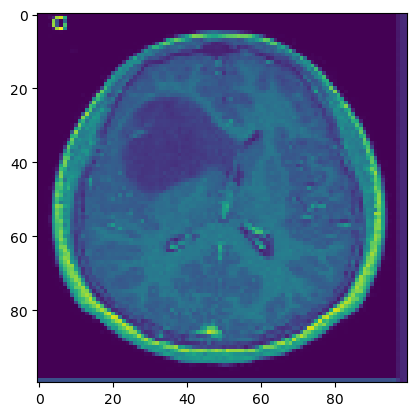

In [33]:
x = 18

pred = predictions[x]
label = y_test[x]

print(f'label:      {label}')
print(f'prediction: {torch.argmax(pred)}')

plt.imshow(x_test[x][0])
plt.show()